2025-04-24 18:52:29.125549: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 18:52:29.174844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 18:52:31.424859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


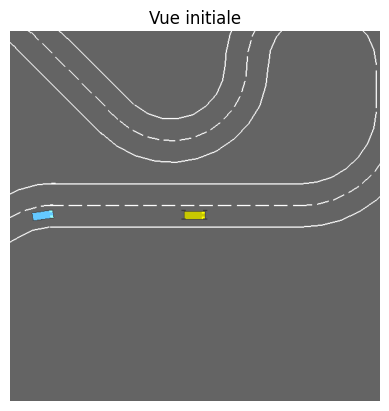

In [1]:

import os, time, pickle, psutil, gymnasium as gym, highway_env      # noqa: F401
import matplotlib.pyplot as plt

from stable_baselines3 import A2C                  # <- CHANGE
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback

ROOT       = os.path.abspath("../")                    # /project/task3
CONFIG_FN  = os.path.join(ROOT, "configs", "config3.pkl")
LOG_DIR    = os.path.join(ROOT, "logs", "a2c_main")   # <- CHANGE
MODEL_DIR  = os.path.join(ROOT, "models")
os.makedirs(LOG_DIR,  exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

with open(CONFIG_FN, "rb") as f:
    cfg = pickle.load(f)

env_vis = gym.make("racetrack-v0", render_mode="rgb_array")
env_vis.unwrapped.configure(cfg)
obs, _ = env_vis.reset()
plt.imshow(env_vis.render()); plt.axis("off"); plt.title("Vue initiale"); plt.show()
env_vis.close()


In [2]:

CORES  = psutil.cpu_count(logical=False)      # ex. 24
N_ENVS = min(22, CORES - 2)                   # 22 envs max
print(f"{N_ENVS=} (CPU physiques : {CORES})")

vec_env = make_vec_env(
    "racetrack-v0",
    n_envs=N_ENVS,
    env_kwargs={"config": cfg},
    vec_env_cls=SubprocVecEnv,
    vec_env_kwargs={"start_method": "fork"},
)


N_STEPS     = 8                      # 8 * N_ENVS ≈ 176 transitions / update
TOTAL_TS    = 100_000        # ← au lieu de 300_000 ou 400_000
             
LR          = 7e-4                   # lr par défaut A2C
GAMMA       = 0.99
ENT_COEF    = 0.0                    # entropy bonus
VF_COEF     = 0.5

policy_kwargs = dict(net_arch=[dict(pi=[256, 256],
                                    vf=[256, 256])])

model = A2C(
    "MlpPolicy",
    vec_env,
    n_steps=N_STEPS,
    learning_rate=LR,
    gamma=GAMMA,
    ent_coef=ENT_COEF,
    vf_coef=VF_COEF,
    policy_kwargs=policy_kwargs,
    tensorboard_log=LOG_DIR,
    verbose=1,
)

eval_env = gym.make("racetrack-v0")
eval_env.unwrapped.configure(cfg)

eval_cb = EvalCallback(
    eval_env,
    eval_freq=25_000,         # un peu plus rare (A2C update + rapide)
    n_eval_episodes=5,
    log_path=LOG_DIR,
    deterministic=True,
)


N_ENVS=22 (CPU physiques : 24)
Using cpu device


/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [3]:

start = time.time()
model.learn(
    total_timesteps=TOTAL_TS,
    tb_log_name="main_run",
    callback=eval_cb,
    progress_bar=True,
)
print("⏱  Durée entraînement :", (time.time() - start) / 60, "min")

model_path = os.path.join(MODEL_DIR, "a2c_racetrack_fast.zip")
model.save(model_path)
with open(model_path.replace(".zip", "_info.txt"), "w") as f:
    f.write(
        f"algo=A2C\nn_envs={N_ENVS}\n"
        f"n_steps={N_STEPS}\n"
        f"lr={LR}\ngamma={GAMMA}\n"
        f"total_ts/env={TOTAL_TS}\n"
    )
print("✓ modèle & méta sauvegardés →", model_path)


Logging to /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/logs/a2c_main/main_run_2


Output()

/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fca18125af0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fc9b770ba40>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 179      |
|    ep_rew_mean        | 112      |
| time/                 |          |
|    fps                | 376      |
|    iterations         | 100      |
|    time_elapsed       | 46       |
|    total_timesteps    | 17600    |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | 0.992    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.48     |
|    std                | 0.989    |
|    value_loss         | 1.96     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | 255      |
| time/                 |          |
|    fps                | 375      |
|    iterations         | 200      |
|    time_elapsed       | 93       |
|    total_timesteps    | 35200    |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | 0.00938  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 1.04     |
|    std                | 0.996    |
|    value_loss         | 0.63     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 425      |
|    ep_rew_mean        | 290      |
| time/                 |          |
|    fps                | 373      |
|    iterations         | 300      |
|    time_elapsed       | 141      |
|    total_timesteps    | 52800    |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | -0.0366  |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | 0.418    |
|    std                | 0.991    |
|    value_loss         | 0.134    |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 551      |
|    ep_rew_mean        | 388      |
| time/                 |          |
|    fps                | 371      |
|    iterations         | 400      |
|    time_elapsed       | 189      |
|    total_timesteps    | 70400    |
| train/                |          |
|    entropy_loss       | -1.36    |
|    explained_variance | -0.00447 |
|    learning_rate      | 0.0007   |
|    n_updates          | 399      |
|    policy_loss        | -0.00246 |
|    std                | 0.942    |
|    value_loss         | 0.0137   |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 487      |
|    ep_rew_mean        | 363      |
| time/                 |          |
|    fps                | 370      |
|    iterations         | 500      |
|    time_elapsed       | 237      |
|    total_timesteps    | 88000    |
| train/                |          |
|    entropy_loss       | -1.31    |
|    explained_variance | 0.00279  |
|    learning_rate      | 0.0007   |
|    n_updates          | 499      |
|    policy_loss        | 0.0313   |
|    std                | 0.893    |
|    value_loss         | 0.0282   |
------------------------------------


⏱  Durée entraînement : 4.510455143451691 min
✓ modèle & méta sauvegardés → /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/models/a2c_racetrack_fast.zip
